### Becoming a Backprop Ninja!

Starting witht the code from `NN_v3` (The NN model with BatchNormalization), the aim is to replace `loss.backward()` with manual backpropagation calculations.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [21]:
BLOCK_SIZE = 3
N_EMBED = 10
N_HIDDEN = 64
N_EPOCHS = 1000
BATCH_SIZE = 32
g = torch.Generator().manual_seed(2147483647)

In [4]:
def createWordsMapping(filename = 'names.txt'):
  words = open(filename, 'r').read().splitlines()
  chars = sorted(list(set(''.join(words))))
  stoi = {s:i+1 for i,s in enumerate(chars)}
  stoi['.'] = 0
  itos = {i:s for s,i in stoi.items()}
  n_vocab = len(stoi)
  return words, stoi, itos, n_vocab

def buildDataset(words, block_size):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

def buildDatasets(words, block_size):
  random.seed(42)
  random.shuffle(words)
  
  n1 = int(0.8 * len(words))
  n2 = int(0.9 * len(words))
  
  Xtr, Ytr = buildDataset(words[:n1], block_size)
  Xdev, Ydev = buildDataset(words[n1:n2], block_size)
  Xte, Yte = buildDataset(words[n2:], block_size)

  return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [30]:
words, stoi, itos, n_vocab = createWordsMapping()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = buildDatasets(words, BLOCK_SIZE)
n_embed, n_hidden, block_size, n_epochs, batch_size = N_EMBED, N_HIDDEN, BLOCK_SIZE, N_EPOCHS, BATCH_SIZE
X, Y = Xtr, Ytr

In [31]:
# Utility function to compare gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad()).item()
  app = torch.allClose(dt, t.grad())
  maxdiff = (dt - t.grad()).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [32]:
C = torch.randn((n_vocab, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3)/((n_embed*block_size) ** 0.5))
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden, n_vocab), generator=g) * 0.1
b2 = torch.randn(n_vocab, generator=g) * 0.1

bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, bngain, bnbias, W2, b2]
static_parameters = [bnmean_running, bnstd_running]

for p in parameters:
  p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 4137


In [33]:
# Minibatch construct
ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
X_batch, Y_batch = X[ix], Y[ix]

In [6]:
# Forward Pass
emb = parameters[0][X_batch] # embed characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatentae the vectors

# Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer preactivation

# Batch Normalization Layer
bnmeani = 1/batch_size * hprebn.mean(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(batch_size-1) * (bndiff2).sum(0, keepdim=True) # Bessel's Correction: dividing by (n-1), not n
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-Linearity
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_batch) # loss function

# Backward Pass
for p in parameters:
  p.grad = None
loss.backward()

# Update Parameters
lr = 0.1 if epoch < 100000 else 0.01 # stop learning rate decay
for p in parameters:
  p.data += -lr * p.grad

In [7]:
@torch.no_grad()
def loss(X, Y, layers, parameters):
  emb = parameters[0][X]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Y)
  return loss

In [8]:
def generateExample(layers, parameters, block_size, itos):
  out = []
  context = [0] * block_size
  while True:
    emb = parameters[0][torch.tensor([context])] # (1,block_size, d)
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
      if isinstance(layer, BatchNorm1d):
        layer.training = False
      x = layer(x)
    probs = F.softmax(x, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  return ''.join(itos[i] for i in out)

def generateExamples(layers, parameters, block_size, itos, numExamples = 20):
  examples = []
  for _ in range(numExamples):
    example = generateExample(layers, parameters, block_size, itos)
    examples.append(example)
  return examples

Total Parameters: 47551
      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1043
  30000/ 200000: 1.9646
  40000/ 200000: 2.2144
  50000/ 200000: 2.2267
  60000/ 200000: 1.7339
  70000/ 200000: 2.1750
  80000/ 200000: 2.1895
  90000/ 200000: 1.8280
 100000/ 200000: 2.3632
 110000/ 200000: 2.2012
 120000/ 200000: 2.1030
 130000/ 200000: 1.8564
 140000/ 200000: 1.8051
 150000/ 200000: 1.9257
 160000/ 200000: 1.8764
 170000/ 200000: 1.8336
 180000/ 200000: 2.2312
 190000/ 200000: 2.0511
Train Loss: 2.010877847671509
Val Loss: 2.0822041034698486
Generated Examples: ['tiavo.', 'deya.', 'brie.', 'araice.', 'isha.', 'roancayse.', 'emreidra.', 'hani.', 'tyleib.', 'chetcalyn.', 'kwistamarin.', 'mara.', 'sole.', 'diottari.', 'lacereaemi.', 'mico.', 'caymona.', 'zaki.', 'leonta.', 'pepp.']


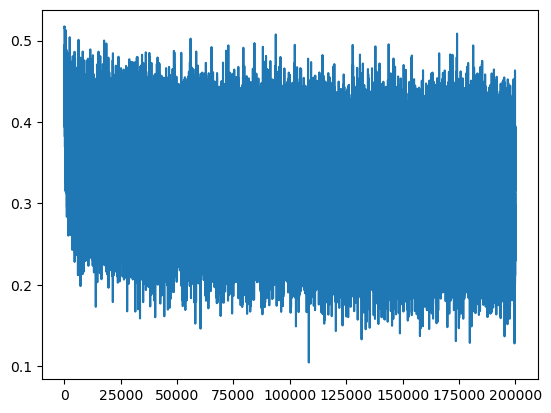

In [15]:
words, stoi, itos, n_vocab = createWordsMapping()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = buildDatasets(words, BLOCK_SIZE)
layers, parameters = initializeModelWeights(n_vocab, BLOCK_SIZE, N_EMBED, N_HIDDEN)
lossi, parameters = trainModel(Xtr, Ytr, layers, parameters, N_EPOCHS, BATCH_SIZE)

plt.plot(lossi)

print(f'Train Loss: {loss(Xtr, Ytr, layers, parameters)}')
print(f'Val Loss: {loss(Xdev, Ydev, layers, parameters)}')

examples = generateExamples(layers, parameters, BLOCK_SIZE, itos)
print(f'Generated Examples: {examples}')